# Band integrated energy loss associated with apparent incoherence

If the wave signal is extracted via bandpass filtering, a widening of the spectrum (via apparent incoherence and a decrease of incoherence timescale for example) may induce a loss of energy as energy leaks out of the filter bandwidth.

Leveraging Caspar-Cohen et al. 2022, the effect of apparent incoherence is assumed to induce the following relationship between Eulerian and Lagrangian incoherence:

$
\begin{align}
C_L(\tau) = C_e(\tau) e^{-\sigma(\tau)k^2/2} \cos \omega \tau, \\
\sigma^2(\tau) = 2 \bar T^2 \bar V^2 \big [ \tau/\bar T - (1-e^{-\tau/\bar T}) \big ]
\end{align}
$

where $C_e(\tau)$ is the autocorrelation of the complex amplitude, $\tau$ is the lag.

The relationship between power spectrum density and autocorrelation is:

$
\begin{align}
E(\omega) = \int_{-\infty}^{\infty} C(\tau) \cos \omega \tau d\tau
\end{align}
$

One can thus compute the Eulerian and Lagrangian power spectrum and the energy within a frequency band around the wave frequency.
The energy loss $L$ associated with apparent incoherence is then the ratio between these energies:

$
\begin{align}
L &= \frac{ \int_{\omega-\delta\omega/2}^{\omega+\delta\omega/2} E_l(\omega) d\omega}{\int_{\omega-\delta\omega/2}^{\omega+\delta\omega/2} E_e(\omega) d\omega}
\end{align}
$


In [1]:
import xarray as xr
import numpy as np

from scipy import stats, fft

import matplotlib.pyplot as plt

In [89]:
def get_lagrangian_energy_loss(omega, bandwidth, ds, 
                               Ce=None, 
                               full_output=False,
                               _factor_dtau=100,
                               _factor_tau_max=100,
                              ):
    """ compute the lagrangian loss of energy following Caspar-Cohen et al. 2022
    
    Parameters
    ----------
    omega: float
        wave frequency
    bandwidth: float
        filter bandwidth
    ds: xr.Dataset
        Dataset containing T, k, Ubar, Tbar
    Ce: lambda
        Eulerian autocorrelation signature must look like Ce(tau, U, T)
    """
    # util params
    day2sec = 86400
    U = 1
    
    # check all variables are here
    input_variables = ["T", "k", "Ubar", "Tbar"]
    assert all([v in ds for v in input_variables]), \
        "one of T, k, Ubar, Tbar is missing from ds"
    ds = ds.set_coords(input_variables)

    # default autocorrelation
    if Ce is None:
        Ce = lambda tau, U, T: U**2 * np.exp(-np.abs(tau/T)) * np.cos(2*np.pi*omega*tau)
    # derives Lagrangian
    sigma = lambda tau, Ub, Tb: Tb*day2sec*Ub*np.sqrt(2*(tau/Tb - (1-np.exp(-np.abs(tau/Tb)))))
    Cl = lambda tau, U, T, k, Ub, Tb: Ce(tau, U, T) * np.exp(- (sigma(tau, Ub, Tb)*k)**2 /2)

    # build lags
    tau_max = T*_factor_tau_max
    dtau = 2*np.pi/omega/_factor_dtau
    ds = ds.assign_coords(tau=("tau", np.arange(0, tau_max, dtau)))
    
    # build covariance
    ds["Ce"] = Ce(ds.tau, U, ds["T"])
    #ds["sigma"] = sigma(ds.tau, ds.Ubar, ds.Tbar)
    #ds["exp_sigma"] = np.exp(- (sigma(ds.tau, ds.Ubar, ds.Tbar)*ds.k)**2 /2)
    ds["Cl"] = Cl(ds.tau, U, ds["T"], ds.k, ds.Ubar, ds.Tbar)

    # build power density spectrum
    N = ds.tau.size
    def dct(C):
        return xr.apply_ufunc(lambda C: fft.dct(C, type=3) * dtau,
                              C,
                              dask="parallelized",
                              input_core_dims=[["tau"]],
                              output_core_dims=[["omega"]],
                              dask_gufunc_kwargs=dict(output_sizes=dict(omega=N)), #[[N]]
                             )
    ds["Ee"] = dct(ds.Ce)
    ds["El"] = dct(ds.Cl)
    ds["omega"] = (2*np.arange(N)+1)/4/N /dtau

    # integrate within filter band
    Ee = (ds.Ee
          .where( np.abs(ds.omega-omega)<bandwidth/2, other=0 )
          .integrate("omega")
         )
    El = (ds.El
          .where( np.abs(ds.omega-omega)<bandwidth/2, other=0 )
          .integrate("omega")
         )
    ds["ratio"] = El/Ee
    if full_output:
        return ds
    else:
        return ds.ratio

In [98]:
# wave
omega = 1 # cpd
T = 10. # days
k = 2*np.pi/100e3 # rad/m

# slow flow
Ubar = np.arange(0.01,10,.01) # m/s
Tbar = 10 # days

# filter
bandwidth = 0.4 # cpd

ds = xr.Dataset(dict(T=T, k=k, Ubar=("x", Ubar), Tbar=Tbar))
# x is here for technical reasons and may represent lon, lat for instance
ds = ds.chunk(dict(x=10)) # dask test

ratio = get_lagrangian_energy_loss(omega, bandwidth, ds)
#ratio = get_lagrangian_energy_loss(omega, bandwidth, ds, _factor_dtau=100, _factor_tau_max=100)
ratio = ratio.swap_dims(dict(x="Ubar"))

(0.0, 1.0)

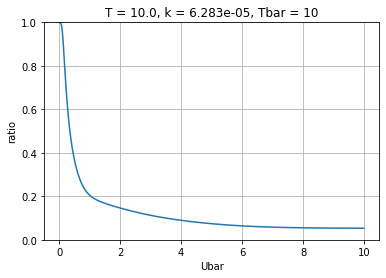

In [99]:
fig, ax = plt.subplots(1,1)
ratio.plot()
ax.grid()
ax.set_ylim(0,1)

---
## dev

In [93]:
# define autocorrelation

# wave
U = 1 # m/s
T = 10. # days
omega = 1 # cpd
k = 2*np.pi/100e3 # rad/m

# slow flow
Ub = .1 # m/s
Tb = 10 # days

# filter
bandwidth = 0.4 # cpd

day2sec = 86400

Ce = lambda tau, U, T: U**2 * np.exp(-abs(tau/T)) * np.cos(2*np.pi*omega*tau)

sigma = lambda tau, Ub, Tb: Tb*day2sec*Ub*np.sqrt(2*(tau/Tb - (1-np.exp(-np.abs(tau/Tb)))))
Cl = lambda tau, U, T, k, Ub, Tb: Ce(tau, U, T) * np.exp(- (sigma(tau, Ub, Tb)*k)**2 /2)

# build lags
tau_max = T*10
dtau = 0.1
tau = np.arange(0, tau_max, dtau)
ds = xr.Dataset(None, coords=dict(tau=("tau", tau)))

# build covariance
ds["Ce"] = ("tau", Ce(tau, U, T))
#ds["sigma"] = ("tau", sigma(tau, Ub, Tb))
ds["Cl"] = ("tau", Cl(tau, U, T, k, Ub, Tb))

# build power density spectrum
N = ds.tau.size
ds["omega"] = (2*np.arange(N)+1)/4/N /dtau
domega = 1/N/dtau
ds["Ee"] = ("omega", fft.dct(ds.Ce.values, type=3) * dtau)
ds["El"] = ("omega", fft.dct(ds.Cl.values, type=3) * dtau)

# integrate within filter band
_E = ds.Ee.where( np.abs(ds.omega-omega)<bandwidth/2, other=0 )
Ee = _E.integrate("omega")
_E = ds.El.where( np.abs(ds.omega-omega)<bandwidth/2, other=0 )
El = _E.integrate("omega")

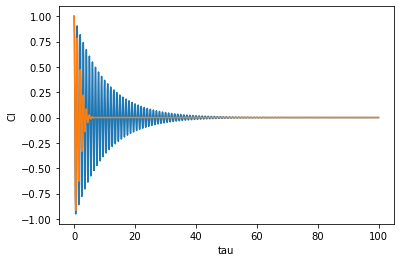

In [94]:
ds.Ce.plot()
ds.Cl.plot()

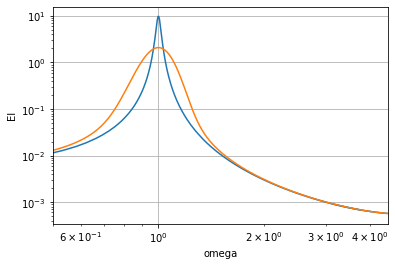

In [95]:
fig, ax = plt.subplots(1,1)
ds["Ee"].plot(xscale="log", yscale="log")
ds["El"].plot(xscale="log", yscale="log")
ax.set_xlim(0.5, 4.5)
ax.grid()

In [96]:
# Check overall energy
ds["Ee"].integrate("omega") / ds.Ce.sel(tau=0, method="nearest") #0.99997106
ds["Ee"].integrate("omega")  / ds.Ce.sel(tau=0, method="nearest") #0.99997106
ds["Ee"].sum("omega")*domega # 1

<xarray.DataArray 'Ee' ()>
array(1.)

In [97]:
Ee, El

(<xarray.DataArray 'Ee' ()>
 array(0.47504943),
 <xarray.DataArray 'El' ()>
 array(0.4585771))